## Introduction

This project builds a probabilistic early-warning model for US recessions using macroeconomic indicators. The model estimates the probability of an NBER-defined recession occurring within the next six months. The focus is on interpretable macro signals and early-warning performance rather than point-prediction accuracy.

## Data

The analysis uses publicly available U.S. macroeconomic data from FRED (Federal Reserve Economic Data). All series are converted to a monthly frequency to ensure consistency across variables. Daily financial series, such as Treasury yields, are aggregated to monthly averages, while other indicators are reported at a monthly frequency by construction.

The sample spans the early 1970s through the present, covering multiple business cycles and recession episodes. The outcome variable is based on the NBER recession indicator, which serves as the benchmark definition of U.S. recessions.

The dataset includes the following variables:

- Treasury yields at different maturities (10-year, 2-year, 3-month)

- Federal funds rate

- Unemployment rate

- Consumer Price Index (CPI)

- Industrial production

- Credit spread proxy

- Recession indicator

Missing observations due to release timing are handled using forward-filling, reflecting the information that would have been available to forecasters at the time. This approach ensures a continuous monthly dataset suitable for time-series modeling.

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas_datareader import data as web
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

start = "1970-01-01"
end = None

series = ["USREC", "DGS10", "DGS2", "TB3MS", "BAA", "UNRATE", "CPIAUCSL", "FEDFUNDS", "INDPRO"]

# Pull from FRED (mix of daily + monthly series)
df = web.DataReader(series, "fred", start, end)

# Monthly frequency (monthly mean is a common choice for daily financial rates)
monthly = df.resample("MS").mean()

# Target: recession indicator 6 months ahead (binary)
monthly["target_rec_6m_ahead"] = (monthly["USREC"].shift(-6) == 1).astype(int)

# Drop the trailing months with undefined target after shifting
monthly = monthly.dropna(subset=["target_rec_6m_ahead"])


## Feature Engineering

Raw macroeconomic series are transformed into economically meaningful features designed to capture financial conditions, labor market dynamics, inflationary pressures, real activity, and monetary policy stance. Feature construction is guided by standard macroeconomic intuition and prior empirical evidence on recession predictors.

Key engineered features include:

- Yield curve slopes (10-year minus 2-year; 10-year minus 3-month), which capture expectations of future economic activity and monetary policy

- Credit spread proxy, reflecting tightening financial conditions and risk aversion

- Unemployment rate changes over short and medium horizons, capturing labor market deterioration

- Year-over-year inflation, measuring price dynamics and demand conditions

- Industrial production growth (year-over-year), capturing real economic activity

- Federal funds rate level and spreads, proxying for monetary policy tightness

Year-over-year growth rates and multi-month changes are used to reduce noise and emphasize cyclical movements. All features are standardized prior to model estimation to ensure comparability of coefficients and numerical stability.

These transformations aim to balance interpretability with predictive content, allowing the model to reflect well-understood macroeconomic mechanisms rather than purely statistical relationships.

In [11]:
# Feature engineering
m = monthly.sort_index().ffill()  # fill small gaps so spreads/changes don't drop too many rows

# Yield curve / rate spreads
m["term_spread_10y_2y"] = m["DGS10"] - m["DGS2"]
m["term_spread_10y_3m"] = m["DGS10"] - m["TB3MS"]
m["spread_10y_ff"] = m["DGS10"] - m["FEDFUNDS"]
m["spread_2y_ff"] = m["DGS2"] - m["FEDFUNDS"]

# Credit spread proxy
m["credit_spread_baa_10y"] = m["BAA"] - m["DGS10"]

# Macro dynamics
m["infl_yoy"] = 100 * m["CPIAUCSL"].pct_change(12)
m["unrate_chg_3m"] = m["UNRATE"] - m["UNRATE"].shift(3)
m["unrate_chg_12m"] = m["UNRATE"] - m["UNRATE"].shift(12)
m["indpro_yoy"] = 100 * m["INDPRO"].pct_change(12)

# Level
m["ffunds_level"] = m["FEDFUNDS"]

feature_cols = [
    "term_spread_10y_2y",
    "term_spread_10y_3m",
    "credit_spread_baa_10y",
    "infl_yoy",
    "unrate_chg_3m",
    "unrate_chg_12m",
    "indpro_yoy",
    "ffunds_level",
    "spread_10y_ff",
    "spread_2y_ff",
]

model_df = m[feature_cols + ["target_rec_6m_ahead"]].dropna()

X = model_df[feature_cols]
y = model_df["target_rec_6m_ahead"].astype(int)

# Time-based train/test split
split_date = "2005-01-01"
X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

# Standardize features using training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Coefficient Interpretation and Threshold Tradeoffs

To better understand the economic signals captured by the model, estimated logistic regression coefficients are examined in both log-odds and odds-ratio form. Because all features are standardized, coefficient magnitudes are directly comparable across variables.

Negative coefficients (odds ratios below one) indicate variables associated with a *lower* probability of entering a recession within six months, while positive coefficients indicate variables associated with *higher* recession risk. Consistent with macroeconomic theory, yield curve slopes and real activity measures load negatively, while short-run labor market deterioration and tighter monetary conditions increase predicted recession risk.

Beyond coefficient interpretation, the model’s classification performance is evaluated across multiple probability thresholds. Lower thresholds increase recall but generate a larger number of false positives, while higher thresholds reduce false positives at the cost of missed recessions. This tradeoff highlights the practical reality that recession forecasting is inherently asymmetric: early warnings favor recall, while policy or investment applications may prefer higher precision.

Rather than relying on a single cutoff, the results emphasize that recession probabilities should be interpreted as *continuous risk signals* whose usefulness depends on the decision context.


In [12]:
# Fit logistic regression
logit = LogisticRegression(
    C=1.0,
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)
logit.fit(X_train_scaled, y_train)

# Predict recession probability (6 months ahead)
y_prob = logit.predict_proba(X_test_scaled)[:, 1]

# ROC-AUC
auc = roc_auc_score(y_test, y_prob)
print(f"Test ROC-AUC: {auc:.3f}")

# Baseline threshold (0.5) + labeled confusion matrix
threshold = 0.50
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual: No recession", "Actual: Recession"],
    columns=["Pred: No recession", "Pred: Recession"]
)
cm_df


Test ROC-AUC: 0.588


,Pred: No recession,Pred: Recession
Actual: No recession,157,76
Actual: Recession,15,5


In [13]:


# Coefficient interpretation (features are standardized => 1 unit = 1 SD)
coef = pd.Series(logit.coef_[0], index=X.columns)

coef_df = (
    pd.DataFrame({
        "coef (log-odds)": coef,
        "odds_ratio": np.exp(coef)
    })
    .sort_values("coef (log-odds)")
)

coef_df


,coef (log-odds),odds_ratio
term_spread_10y_3m,-1.930161,0.145125
indpro_yoy,-1.468552,0.230259
unrate_chg_12m,-0.696791,0.498182
infl_yoy,-0.646438,0.523909
term_spread_10y_2y,-0.184754,0.831309
credit_spread_baa_10y,-0.143803,0.866058
spread_10y_ff,0.130454,1.139345
spread_2y_ff,0.365561,1.441323
unrate_chg_3m,1.051295,2.861354
ffunds_level,1.180351,3.255515


In [16]:
from sklearn.metrics import precision_score, recall_score

for t in [0.20, 0.25, 0.30, 0.50]:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec  = recall_score(y_test, y_pred_t, zero_division=0)

    print(
        f"threshold={t:.2f} | TP={tp}, FP={fp}, FN={fn}, TN={tn} | "
        f"precision={prec:.2f}, recall={rec:.2f}"
    )


threshold=0.20 | TP=11, FP=104, FN=9, TN=129 | precision=0.10, recall=0.55
threshold=0.25 | TP=8, FP=98, FN=12, TN=135 | precision=0.08, recall=0.40
threshold=0.30 | TP=6, FP=93, FN=14, TN=140 | precision=0.06, recall=0.30
threshold=0.50 | TP=5, FP=76, FN=15, TN=157 | precision=0.06, recall=0.25


### Predicted Recession Risk Over Time

This figure plots the model’s predicted probability of entering an NBER recession within the next six months. Shaded regions indicate NBER recession months. The dashed horizontal line highlights a reference early-warning threshold used for the alert visualization below.


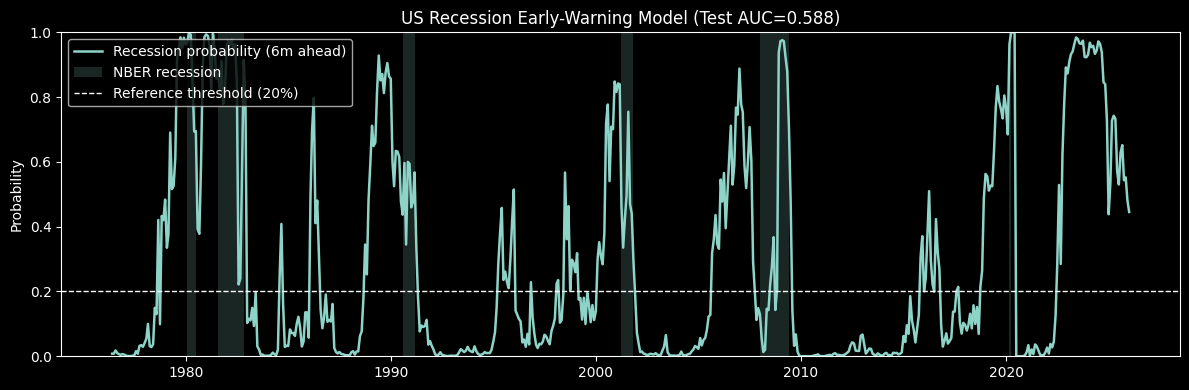

In [17]:
# Full-sample predicted probabilities (6 months ahead)
probs_full = logit.predict_proba(scaler.transform(X))[:, 1]
prob_series = pd.Series(probs_full, index=X.index, name="p_recession_6m")

# Plot probability over time with NBER recession shading
plt.figure(figsize=(12, 4))

plt.plot(prob_series, label="Recession probability (6m ahead)", linewidth=1.8)

recession_mask = (
    monthly["USREC"]
    .reindex(prob_series.index)
    .fillna(0)
    .astype(int)
    .astype(bool)
)

plt.fill_between(
    prob_series.index, 0, 1,
    where=recession_mask,
    alpha=0.18,
    label="NBER recession"
)

threshold = 0.20
plt.axhline(threshold, linestyle="--", linewidth=1, label=f"Reference threshold ({int(threshold*100)}%)")

plt.title(f"US Recession Early-Warning Model (Test AUC={auc:.3f})")
plt.ylim(0, 1)
plt.ylabel("Probability")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


### Binary Early-Warning Alerts

To visualize the model as an early-warning signal, predicted probabilities are converted into a binary alert using a chosen threshold. This makes the tradeoff between missed recessions and false alarms explicit.


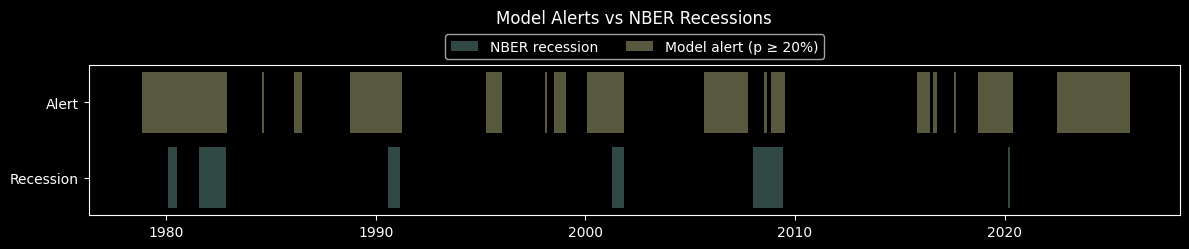

In [23]:
# Binary alert visualization (thresholded probabilities)
threshold = 0.20

idx = prob_series.index
usrec = monthly["USREC"].reindex(idx).fillna(0).astype(int)
alert = (prob_series >= threshold).astype(int)

plt.figure(figsize=(12, 2.6))

plt.fill_between(
    idx, 0.00, 0.45,
    where=(usrec == 1),
    step="post",
    alpha=0.35,
    label="NBER recession"
)

plt.fill_between(
    idx, 0.55, 1.00,
    where=(alert == 1),
    step="post",
    alpha=0.35,
    label=f"Model alert (p ≥ {int(threshold*100)}%)"
)

plt.ylim(-0.05, 1.05)
plt.yticks([0.225, 0.775], ["Recession", "Alert"])
plt.title("Model Alerts vs NBER Recessions", pad=30)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=True)
plt.tight_layout()
plt.show()


### Model Interpretability: Coefficients

Because features are standardized, coefficient magnitudes can be compared directly. The chart below summarizes which signals are most associated with higher or lower recession risk in the fitted model.


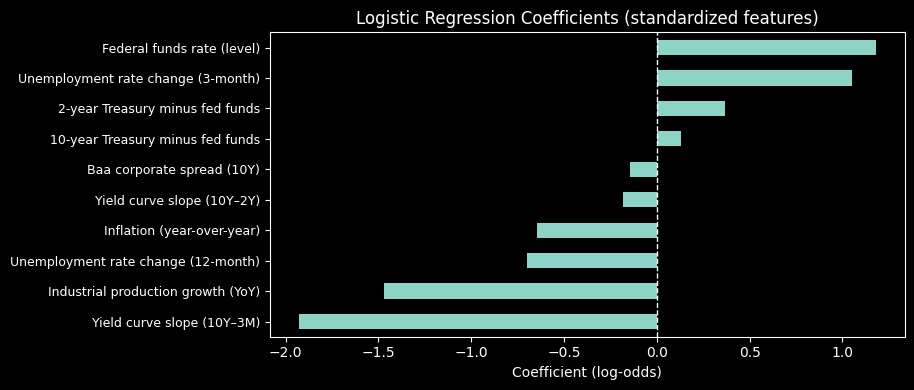

In [27]:
pretty_labels = {
    "ffunds_level": "Federal funds rate (level)",
    "unrate_chg_3m": "Unemployment rate change (3-month)",
    "spread_2y_ff": "2-year Treasury minus fed funds",
    "spread_10y_ff": "10-year Treasury minus fed funds",
    "credit_spread_baa_10y": "Baa corporate spread (10Y)",
    "term_spread_10y_2y": "Yield curve slope (10Y–2Y)",
    "infl_yoy": "Inflation (year-over-year)",
    "unrate_chg_12m": "Unemployment rate change (12-month)",
    "indpro_yoy": "Industrial production growth (YoY)",
    "term_spread_10y_3m": "Yield curve slope (10Y–3M)",
}

coef_df_pretty = coef_df.rename(index=pretty_labels)

plt.close("all")

ax = coef_df_pretty["coef (log-odds)"].sort_values().plot(
    kind="barh",
    figsize=(10, 4)
)

ax.axvline(0, linewidth=1, linestyle="--")
ax.tick_params(axis="y", labelsize=9)
ax.set_title("Logistic Regression Coefficients (standardized features)")
ax.set_xlabel("Coefficient (log-odds)")

plt.tight_layout()
plt.subplots_adjust(left=0.35)
plt.show()




### Interpretation (6-Month Horizon)

The model’s predicted recession probability responds systematically to changes in macroeconomic and financial conditions. Periods of yield curve flattening or inversion and widening credit spreads are associated with higher estimated recession risk, while stronger real activity and a steeper yield curve correspond to lower predicted probabilities. These relationships are consistent with established macroeconomic theory and historical evidence.

The estimated logistic regression coefficients reinforce this interpretation. Tighter monetary policy, rising unemployment, and widening credit spreads are associated with higher recession risk, whereas stronger industrial production growth and steeper yield curve slopes are associated with lower risk. Because all inputs are standardized, the coefficients are directly comparable and highlight the relative importance of financial conditions alongside real-economy indicators.

The probability-based framework emphasizes gradual changes in recession risk rather than abrupt binary signals. As economic conditions deteriorate, the model raises recession probabilities well in advance of several major downturns, including the early 1980s recessions, the Global Financial Crisis, and the COVID-19 recession. This behavior supports the use of the model as an early-warning and risk-monitoring tool rather than a precise timing device.

Because recessions are rare events, a conventional 50 percent classification threshold is overly conservative. Lower early-warning thresholds, approximately 20 to 25 percent, improve recession detection at the cost of additional false positives. This tradeoff is appropriate in macroeconomic surveillance settings, where the costs of missing a recession often exceed the costs of issuing false alarms.

Finally, the alert timeline shows that some warnings persist beyond officially dated NBER recession periods, most notably in 2020. This reflects the model’s focus on elevated economic risk rather than the duration of realized downturns, as financial stress and uncertainty remained high even after the formal recession ended.

Overall, the results indicate that incorporating financial conditions, particularly yield curve slopes and credit spreads, meaningfully improves recession risk assessment and provides economically interpretable signals for monitoring cyclical turning points.

## Limitations

Several limitations should be considered when interpreting the results. First, recessions are rare events, which inherently constrains predictive performance and leads to imbalanced classification outcomes. As a result, evaluation metrics such as ROC–AUC should be interpreted as measures of relative risk ranking rather than precise point forecasts of recession timing.

Second, the analysis relies on revised historical data rather than real-time data vintages. In practice, macroeconomic indicators are subject to revisions, and forecasting performance using information available at the time may differ from results obtained with finalized data releases.

Third, the COVID-19 recession represents a structural break driven largely by non-economic shocks. This episode may distort coefficient estimates and inflate predicted risk during that period. Addressing such events would require more flexible modeling approaches or explicit controls for exogenous shocks.

Finally, the logistic regression framework is inherently linear and may not capture nonlinear relationships or complex interactions among macroeconomic variables. While this choice supports transparency and interpretability, alternative nonlinear models could potentially improve predictive performance at the cost of reduced interpretability.

## Conclusions

This project develops a probabilistic early-warning model for U.S. recessions using macroeconomic and financial indicators. By focusing on recession risk rather than point forecasts of economic growth, the analysis emphasizes interpretability, time-series-appropriate evaluation, and the tradeoff between early detection and false alarms.

The results show that incorporating financial conditions, particularly yield curve slopes and credit spread proxies, improves the model’s ability to identify periods of elevated recession risk. While overall predictive performance remains modest, with an out-of-sample ROC–AUC of approximately 0.59, this outcome is consistent with the inherent difficulty of forecasting rare macroeconomic events. Importantly, the model captures economically meaningful risk dynamics and raises recession probabilities ahead of several major downturns.

Threshold analysis demonstrates that lower probability cutoffs, approximately 20 to 25 percent, substantially improve recession detection at the cost of increased false positives. This tradeoff reinforces the interpretation of the model as a risk-monitoring and early-warning tool rather than a precise timing device. In this context, sustained increases in estimated risk are often more informative than binary recession classifications.

Overall, the project illustrates that relatively simple and interpretable models, when paired with economically motivated features and appropriate evaluation methods, can provide useful insights into cyclical risk. Future extensions could incorporate real-time data vintages, alternative recession definitions, or nonlinear modeling approaches to further enhance early-warning performance.